In [1]:
import sys
sys.path.insert(0, "/home/broerman/crispy_shifty/")
from crispy_shifty.utils.io import gen_array_tasks

design_list_file = "/home/broerman/crispy_shifty/projects/DAB/round_1/design/02_mpnn_structure/mpnn_inpaints.pair"

simulation_name = "03_fold_complex"
output_path = f"/home/broerman/crispy_shifty/projects/DAB/round_1/design/{simulation_name}"

options = " ".join(
    [
        "out:level 100",
    ]
)
extra_kwargs = {"models": "all", "use_filter": "false", "use_initial_guess": "true"}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.folding.fold_bound_state",
    design_list_file=design_list_file,
    output_path=output_path,
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    sha1=None,
    queue="gpu",
    time="01:00:00",
    gres="--gres=gpu:a4000:1"
)

Run the following command with your desired environment active:
sbatch -a 1-180 /home/broerman/crispy_shifty/projects/DAB/round_1/design/03_fold_complex/run.sh


In [2]:
import os
import sys
sys.path.insert(0, "/home/broerman/crispy_shifty")

simulation_name = "03_fold_complex"
output_path = f"/home/broerman/crispy_shifty/projects/DAB/round_1/design/{simulation_name}"

In [ ]:
from crispy_shifty.utils.io import collect_score_file

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

In [2]:
from crispy_shifty.utils.io import parse_scorefile_linear

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

  0%|          | 0/1620 [00:00<?, ?it/s]

In [5]:
import numpy as np
scores_df["designed_by"] = np.where(scores_df["designed_by"] == "mpnn", "mpnn", "inpainting")
reindex_cols = ['mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'model', 'pTMscore', 'recycles', 'rmsd_to_reference', 'seed', 'tol']
scores_df.rename({col: f"Y_{col}" for col in reindex_cols}, axis=1, inplace=True)

In [3]:
import pandas as pd

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col=0)

5it [00:00, 16.06it/s]


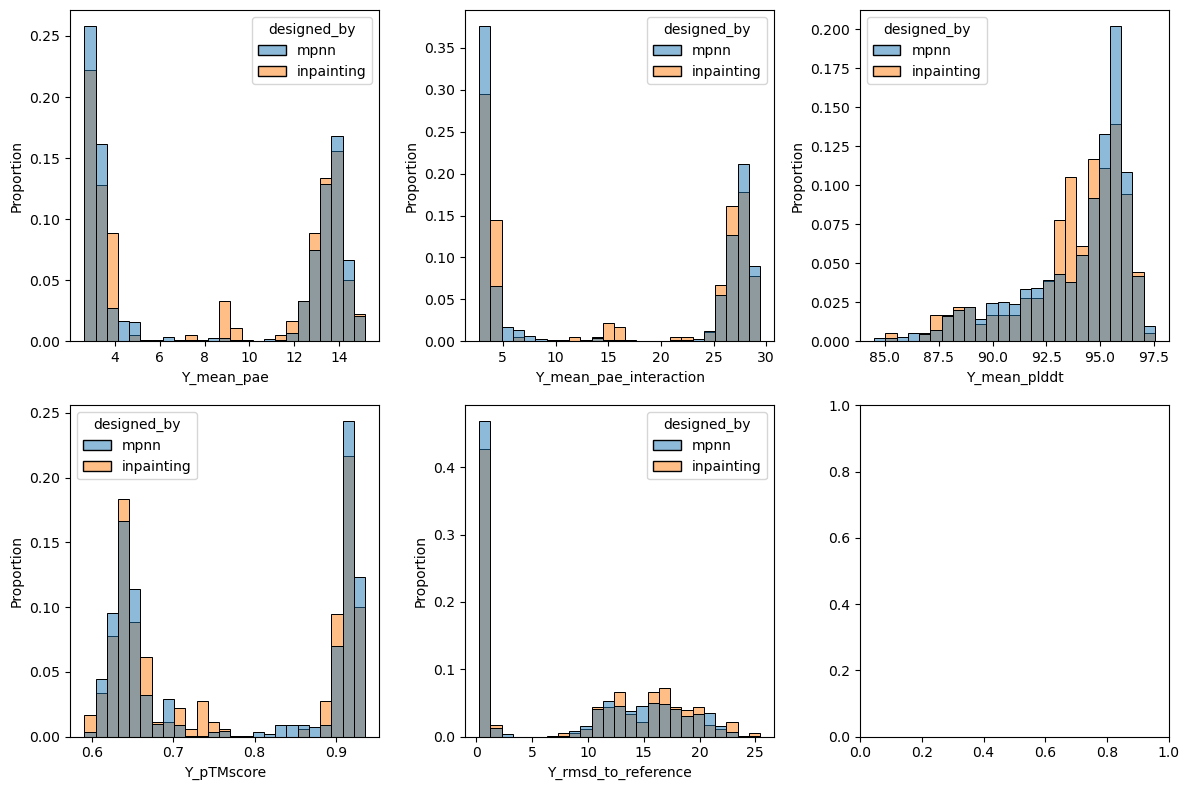

In [8]:
import matplotlib.pyplot as plt
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

cols = [
    "Y_mean_pae",
    "Y_mean_pae_interaction",
    "Y_mean_plddt",
    "Y_pTMscore",
    "Y_rmsd_to_reference",
]
the_fig = histplot_df(
    df=scores_df,
    cols=cols,
    bins=25,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)
plt.savefig(os.path.join(output_path, "af2_scores_all.png"))

In [9]:
filtered_df = scores_df.query("Y_rmsd_to_reference < 3")

In [10]:
filtered_df.parent.value_counts().sort_index()

JHB_07ABr2         88
cs_201r1            4
cs_203r2           73
cs_207_left        38
cs_207_right1      87
cs_207_right2      78
cs_221             22
cs_230_straight    25
cs_230_twist        6
cs_242             51
cs_243             20
cs_244_straight    10
cs_244_twist        7
cs_245              2
cs_269_straight    82
cs_269_twist       59
cs_287             39
cs_292             88
Name: parent, dtype: int64

5it [00:00, 24.72it/s]


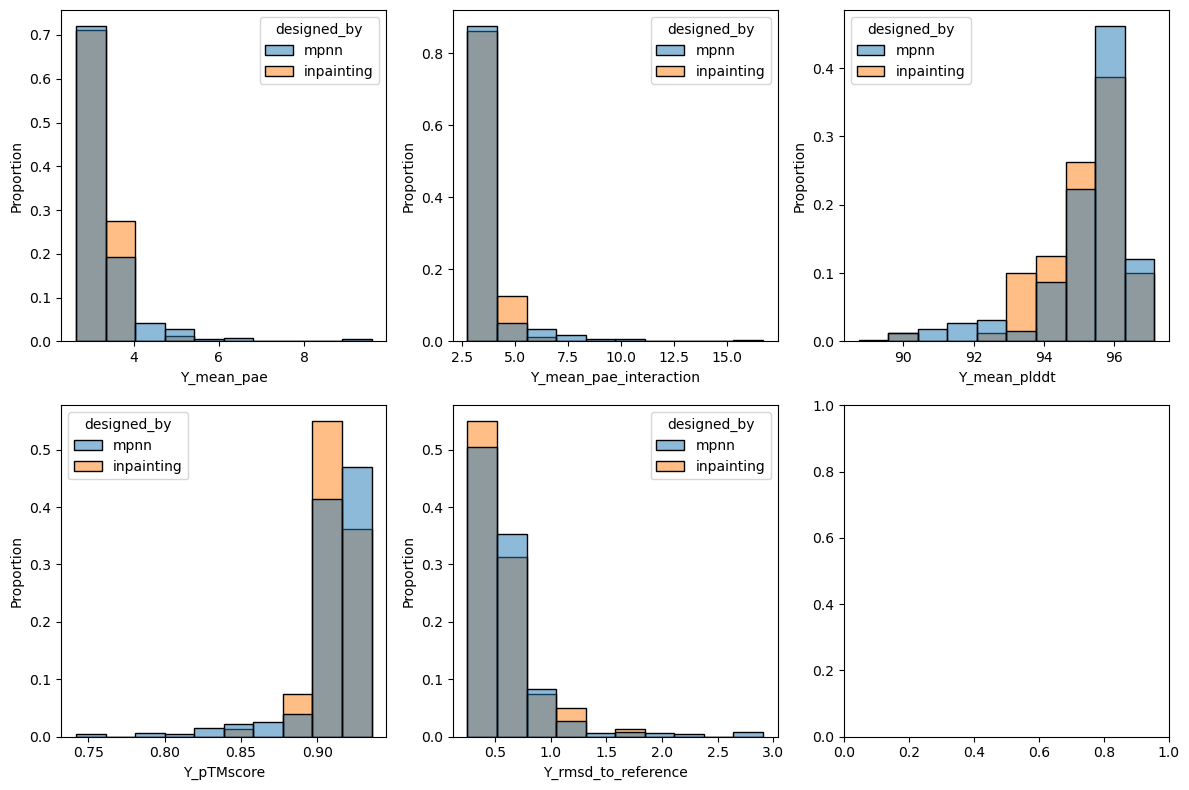

In [11]:
the_fig = histplot_df(
    df=filtered_df,
    cols=cols,
    bins=10,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)
plt.savefig(os.path.join(output_path, "af2_scores.png"))

In [4]:
# remove outliers
filtered_df = scores_df.query("Y_mean_pae < 5 and Y_mean_pae_interaction < 6 and Y_mean_plddt > 92 and Y_rmsd_to_reference < 3")
len(filtered_df)

731

In [7]:
def get_len_dab(row):
    dab_contig = row["sampled_mask"].split(';')[1]
    len_dab = 0
    for contig in dab_contig.split(','):
        if contig[0].isalpha():
            start, end = [int(x) for x in contig[1:].split('-')]
            len_dab += end - start + 1
        else:
            len_dab += int(contig.split('-')[0])
    return len_dab

filtered_df["len_dab"] = filtered_df.apply(get_len_dab, axis=1)
filtered_df.sort_values("len_dab", inplace=True, ascending=False)

In [13]:
filtered_df.parent.value_counts().sort_index()

JHB_07ABr2         87
cs_201r1            3
cs_203r2           72
cs_207_left        38
cs_207_right1      87
cs_207_right2      78
cs_221             22
cs_230_straight    24
cs_230_twist        6
cs_242             14
cs_243             20
cs_244_straight    10
cs_244_twist        7
cs_245              2
cs_269_straight    79
cs_269_twist       59
cs_287             39
cs_292             84
Name: parent, dtype: int64

In [11]:
with open(os.path.join(output_path, "folded_structures.list"), "w") as f:
    for path in filtered_df.index:
        print(path, file=f)